In [1]:
%load_ext autoreload
%autoreload 2


In [2]:

import torch
from diff_music.models.feature_extractor import FeatureExtractor
from diff_music.models.midilike_transformer import SymbolicRepresentation

params = FeatureExtractor.Params(dim=64, num_layers=2, pitch_range=[21, 109], max_len=100, reduce=False)
fe = FeatureExtractor(params)



In [3]:
fe.transformer.layers[0].self_attn.out_proj.weight

Parameter containing:
tensor([[ 0.0260,  0.0137, -0.0450,  ..., -0.0894, -0.0669,  0.1219],
        [ 0.0017,  0.0518,  0.0354,  ...,  0.1044,  0.1080,  0.0111],
        [ 0.0249, -0.1143,  0.0515,  ...,  0.0486,  0.0002, -0.0877],
        ...,
        [ 0.0403, -0.1062,  0.0388,  ...,  0.0263, -0.0706, -0.0337],
        [ 0.0672,  0.0324, -0.1198,  ...,  0.0110, -0.0116,  0.0528],
        [ 0.0776, -0.0543, -0.0196,  ..., -0.0802,  0.0508,  0.0338]],
       requires_grad=True)

In [5]:
fe.eval()

input = SymbolicRepresentation(
    token=torch.tensor([[[60, 100], [62, 100], [64, 100], [65, 100], [67, 100], [69, 100], [71, 100]]]),
    token_type=torch.tensor([[0, 0, 1, 0, 1, 1, 0]]),
    pos=torch.tensor([[0, 0, 1, 1, 2, 2, 2]]),
)
output = fe(input)
print(output[:,:,:3])

input = SymbolicRepresentation(
    token=torch.tensor([[[60, 100], [62, 100], [0,0], [64, 100], [65, 100], [67, 100], [69, 100], [71, 100]]]),
    token_type=torch.tensor([[0, 0, -1, 1, 0, 1, 1, 0]]),
    pos=torch.tensor([[0, 0, 0, 1, 1, 2, 2, 2]]),
)
output = fe(input)
print(output[:,:,:3])


tensor([[0., 0., 0., 0., 0., 0., 0.]])
tensor([[[-4.8680e-01, -4.0574e-01, -2.7843e-01],
         [-4.8680e-01, -4.0574e-01, -2.7843e-01],
         [-8.3252e-01, -1.0753e-03,  9.6645e-01],
         [ 6.2992e-03,  1.7091e-01, -5.5561e-01],
         [-1.2280e+00,  3.4511e-01,  1.1309e+00],
         [-1.0650e+00,  8.1205e-02, -4.6016e-01],
         [-5.2108e-01,  6.6390e-01, -9.6715e-01]]], grad_fn=<SliceBackward0>)
tensor([[0., 0., -inf, 0., 0., 0., 0., 0.]])
tensor([[[-4.8680e-01, -4.0574e-01, -2.7843e-01],
         [-4.8680e-01, -4.0574e-01, -2.7843e-01],
         [-6.2118e-01, -1.2567e+00, -3.1179e-01],
         [-8.3252e-01, -1.0750e-03,  9.6645e-01],
         [ 6.2992e-03,  1.7091e-01, -5.5561e-01],
         [-1.2280e+00,  3.4511e-01,  1.1309e+00],
         [-1.0650e+00,  8.1205e-02, -4.6016e-01],
         [-5.2108e-01,  6.6390e-01, -9.6715e-01]]], grad_fn=<SliceBackward0>)


In [21]:
input.is_pad


tensor([[False, False,  True, False, False, False, False, False]])

# Compare cross entropy and kl divergence using simple example

Let there be a target distribution p. We have three candidates that try to approximate p: q1, q2, q3.

First we contruct p.


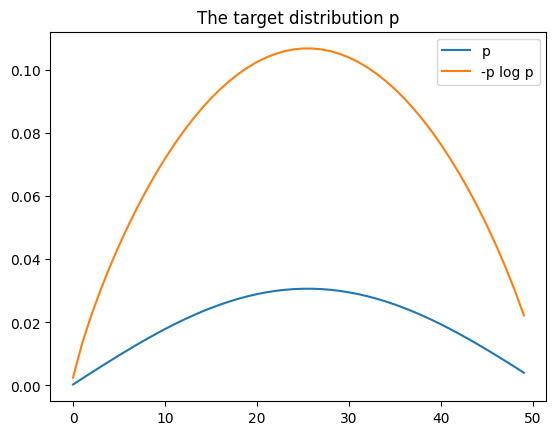

In [79]:
from matplotlib import pyplot as plt
import torch

def normalize(x: torch.Tensor):
    return x / x.sum()

p = torch.sin(torch.linspace(0, 3, 50) + 1e-2)
p = normalize(p)

plt.title('The target distribution p')
plt.plot(p, label='p')
plt.plot(-p * torch.log(p), label='-p log p')
plt.legend()


Where `-p log p` contributes to the entropy of p.

Now we construct q1, q2, q3. They underestimate p in the range of [30, 33] for a little bit.

The error of q1, q2, q3 sort of linearly increases.

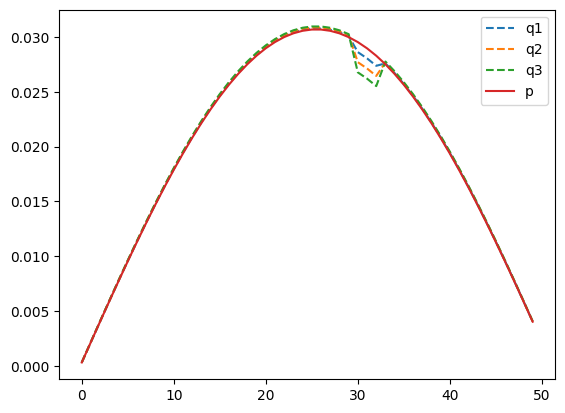

In [81]:
q1 = p.clone()
q1[30:33] -= 0.001
q1 = normalize(q1)

q2 = p.clone()
q2[30:33] -= 0.002
q2 = normalize(q2)

q3 = p.clone()
q3[30:33] -= 0.003
q3 = normalize(q3)

plt.plot(q1, label='q1', linestyle='--')
plt.plot(q2, label='q2', linestyle='--')
plt.plot(q3, label='q3', linestyle='--')
plt.plot(p, label='p')

plt.legend()
plt.show()



For kl divergence, we have D(p||q1) = sum(p log p / q1 log q1).
By ommiting the sum, we can see how each part of x contributes to the kl divergence.

You can see that the positive contribution to the kl divergence is close to linear for q1, q2, and q3, wihch matches how we designed them.

kld(p||q1) tensor(4.8513e-05)
kld(p||q2) tensor(0.0002)
kld(p||q3) tensor(0.0005)


<BarContainer object of 3 artists>

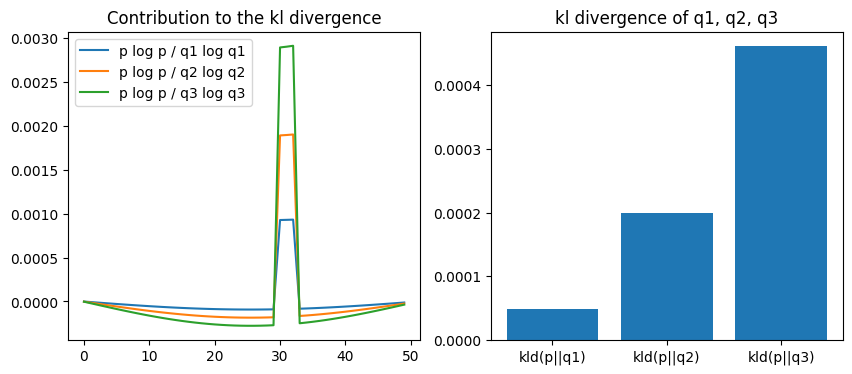

In [103]:
p_log_p_over_q1 = p * torch.log(p/q1)
p_log_p_over_q2 = p * torch.log(p/q2)
p_log_p_over_q3 = p * torch.log(p/q3)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].title.set_text('Contribution to the kl divergence')
ax[0].plot(p_log_p_over_q1, label='p log p / q1 log q1')
ax[0].plot(p_log_p_over_q2, label='p log p / q2 log q2') 
ax[0].plot(p_log_p_over_q3, label='p log p / q3 log q3')
ax[0].legend()

print('kld(p||q1)', p_log_p_over_q1.sum())
print('kld(p||q2)', p_log_p_over_q2.sum())
print('kld(p||q3)', p_log_p_over_q3.sum())

ax[1].title.set_text('kl divergence of q1, q2, q3')
ax[1].bar(['kld(p||q1)', 'kld(p||q2)', 'kld(p||q3)'], [p_log_p_over_q1.sum(), p_log_p_over_q2.sum(), p_log_p_over_q3.sum()])


Now, let's see how each part of x contributes to the cross entropy. We can see that the cross entropy is mostly not caused by the error.

The entropy of p itself overwhelms the effect of the error.

H(p, q1) tensor(3.7845)
H(p, q2) tensor(3.7847)
H(p, q3) tensor(3.7850)


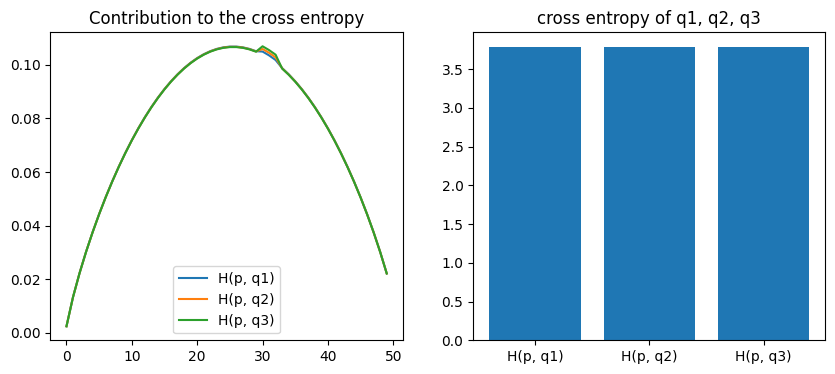

In [105]:
neg_p_log_q1 = -p * torch.log(q1)
neg_p_log_q2 = -p * torch.log(q2)
neg_p_log_q3 = -p * torch.log(q3)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].title.set_text('Contribution to the cross entropy')
ax[0].plot(neg_p_log_q1, label='H(p, q1)')
ax[0].plot(neg_p_log_q2, label='H(p, q2)')
ax[0].plot(neg_p_log_q3, label='H(p, q3)')
ax[0].legend()

print('H(p, q1)', neg_p_log_q1.sum())
print('H(p, q2)', neg_p_log_q2.sum())
print('H(p, q3)', neg_p_log_q3.sum())

ax[1].title.set_text('cross entropy of q1, q2, q3')
ax[1].bar(['H(p, q1)', 'H(p, q2)', 'H(p, q3)'], [neg_p_log_q1.sum(), neg_p_log_q2.sum(), neg_p_log_q3.sum()])

plt.show()

## Conclusion

KL divergence is a better and more intuitive metric to measure the distance between two distributions.

Though, cross entropy works as well as KL divergence if p is constant and we only care about the gradient of the error.

If we care about the absolute metric value, KL divergence gives more intuitive results.